# Dynamic Content Understanding: Advanced Video Analysis with Amazon Bedrock

Welcome to the video analysis module of our multimodal data processing journey with Amazon Bedrock Data Automation (BDA). In previous modules, we explored foundation building with document analysis and seeing beyond text with image analysis, and unlocking the voice of information with audio analysis. Now, we're diving into perhaps the most complex and information-rich modality: video.

## Why Video Analysis Matters

Video represents the most information-dense form of content, combining visual elements, motion, audio, and text into a temporal flow. This richness makes video exceptionally valuable but also challenging to process with traditional methods.

Consider that:
- A single minute of video contains approximately 1,800 frames (at 30 fps)
- The average enterprise has thousands of hours of video content that remains largely unsearchable
- Manual video analysis costs $15-25 per minute of processed content
- Only 1-2% of video content is typically leveraged in business intelligence systems

Amazon Bedrock Data Automation transforms this landscape by enabling us to automatically:
- Detect and analyze distinct scenes and shots
- Generate comprehensive video summaries and chapter breakdowns
- Extract text visible within the video frames
- Identify logos and brands
- Apply content moderation across visual and audio components
- Classify content using standardized IAB categories

This capability fundamentally changes how we interact with video content, unlocking insights that were previously trapped in the visual medium.

## Setting Up Our Environment

Let's begin by installing required libraries and importing dependencies. We'll be using our enhanced utility functions that incorporate the "Dynamic Content Understanding" theme.

In [13]:
import os
import warnings
os.environ['PIP_DISABLE_PIP_VERSION_CHECK'] = '1'
os.environ['PIP_NO_WARN_SCRIPT_LOCATION'] = '1'
warnings.filterwarnings('ignore')

# Install required packages with maximum suppression
%pip install "boto3>=1.37.4" "matplotlib" "moviepy" --upgrade --quiet --disable-pip-version-check 2>/dev/null

# Import necessary libraries
import boto3
import json
import uuid
import time
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Video, clear_output, HTML, display, Markdown

# Import our video utilities from the consolidated utils module
from utils.utils import BDAVideoUtils, show_business_context, ensure_bda_results_dir

# Initialize our utility class
bda_utils = BDAVideoUtils()
print(f"Setup complete. BDA utilities initialized for region: {bda_utils.current_region}")
print(f"Using S3 bucket: {bda_utils.bucket_name}")

# Display business context for video analysis
show_business_context("video_complete")


Note: you may need to restart the kernel to use updated packages.
Bucket bda-workshop-us-west-2-033741858282 already exists
Setup complete. BDA utilities initialized for region: us-west-2
Using S3 bucket: bda-workshop-us-west-2-033741858282



Video is the most information-dense form of content, combining visual elements, motion, audio, and text in a temporal flow. 
Amazon Bedrock Data Automation (BDA) unlocks the hidden value in video content by extracting structured insights from these 
complex, multimodal assets.

### Core Business Capabilities

- **Visual Understanding**: Extract scenes, objects, people, text, and logos from video frames
- **Temporal Analysis**: Understand how content changes over time with chapter detection
- **Content Classification**: Automatically categorize video content using IAB taxonomies (24 top-level categories)
- **Multimodal Integration**: Combine visual analysis with transcript and audio processing
- **Content Moderation**: Identify potentially sensitive or inappropriate content across 7 official categories
- **Summarization**: Generate concise overviews of video content for improved discoverability
- **Shot and Chapter Analysis**: Break down videos into meaningful segments with detailed metadata

### Industry Applications

- **Media & Entertainment**
  - Automated content cataloging and metadata generation
  - Content moderation for user-generated videos
  - Personalized content recommendations based on visual elements
  - Enhanced search capabilities through extracted visual concepts

- **Advertising & Marketing**
  - Brand and logo detection in sponsored content
  - Competitive analysis of video marketing campaigns
  - Contextual ad placement based on video topics and scenes
  - IAB taxonomy classification for targeted advertising

- **Retail & E-commerce**
  - Product detection and feature extraction from video reviews
  - Visual merchandising analysis from store videos
  - Creation of shoppable video experiences
  - Trend analysis from fashion and lifestyle videos

- **Security & Compliance**
  - Content policy enforcement for video platforms
  - Identification of unauthorized brand usage
  - Detection of potentially harmful or unsafe content
  - Monitoring of video content for regulatory compliance

### ROI Opportunities

- Reduce manual review costs by 60-80% through automated video analysis
- Increase video asset value by 40-50% through enhanced discoverability
- Accelerate time-to-market for video content by automating metadata creation
- Enable new revenue streams through improved content understanding
- Reduce risk with automated content moderation at scale

### Video Analysis Evolution

Before generative AI, video analysis required complex pipelines with separate models for object detection, 
scene analysis, text recognition, and content classification. These systems were costly, slow, and often 
inaccurate. BDA unifies these capabilities into a single, powerful API that delivers comprehensive video insights 
with unprecedented speed and accuracy.


## 1. Prepare Sample Video

First, we'll download a sample video and upload it to S3 for processing with BDA. We'll use a short video that contains various elements that BDA can analyze, including different scenes, spoken content, and visual elements.

The video will be stored in an S3 bucket that BDA can access. This step follows the same pattern we used for document, image, and audio processing, where we first need to have the content accessible in S3.

In [2]:
# Download sample video using our enhanced utility function
sample_video = 'content-moderation-demo.mp4'
source_url = 'https://ws-assets-prod-iad-r-pdx-f3b3f9f1a7d6a3d0.s3.us-west-2.amazonaws.com/335119c4-e170-43ad-b55c-76fa6bc33719/NetflixMeridian.mp4'

# Download the video with enhanced error handling
try:
    bda_utils.download_video(source_url, sample_video)
    print(f"Successfully downloaded video to {sample_video}")
except Exception as e:
    print(f"Error downloading video: {e}")

# Display the video in the notebook for preview
display(Video(sample_video, width=800))

# Upload to S3 for BDA processing
s3_key = f'{bda_utils.data_prefix}/{sample_video}'
s3_uri = bda_utils.upload_to_s3(sample_video, s3_key)
print(f"Uploaded video to S3: {s3_uri}")

Downloaded https://ws-assets-prod-iad-r-pdx-f3b3f9f1a7d6a3d0.s3.us-west-2.amazonaws.com/335119c4-e170-43ad-b55c-76fa6bc33719/NetflixMeridian.mp4 to content-moderation-demo.mp4
Successfully downloaded video to content-moderation-demo.mp4


Uploaded video to S3: s3://bda-workshop-us-west-2-033741858282/bda-workshop/video/content-moderation-demo.mp4


## 2. Define BDA Configuration and Create Project

Now we'll define the standard output configuration for video analysis and create a BDA project. This configuration determines what information BDA will extract from the video.

### Video Processing Capabilities

BDA offers specialized processing options for video content:

In [3]:
# Display business context for video chapters
show_business_context("chapter_detection")

# Define standard output configuration for video processing
standard_output_config = {
    'video': {
        'extraction': {
            'category': {
                'state': 'ENABLED',
                'types': [
                    'CONTENT_MODERATION',  # Detect inappropriate content
                    'TEXT_DETECTION',      # Extract text from the video
                    'TRANSCRIPT',          # Generate transcript of spoken content
                    'LOGOS'                # Identify brand logos
                ]
            },
            'boundingBox': {
                'state': 'ENABLED'         # Include bounding boxes for detected elements
            }
        },
        'generativeField': {
            'state': 'ENABLED',
            'types': [
                'VIDEO_SUMMARY',           # Generate overall video summary
                'CHAPTER_SUMMARY',         # Generate summaries for each chapter
                'IAB'                      # Classify into IAB categories
            ]
        }
    }
}

# Create a BDA project with our standard output configuration
print("Creating BDA project for video analysis...")
response = bda_utils.bda_client.create_data_automation_project(
    projectName=f'bda-workshop-video-project-{str(uuid.uuid4())[0:4]}',
    projectDescription='BDA workshop video sample project',
    projectStage='DEVELOPMENT',
    standardOutputConfiguration=standard_output_config
)

# Get the project ARN
video_project_arn = response.get("projectArn")
print(f"BDA project created with ARN: {video_project_arn}")


Chapter detection is a foundational capability that transforms how organizations work with video content.
By automatically segmenting videos into meaningful chapters, BDA enables deeper understanding and more
efficient video content management.

### Business Applications

- **Improved Navigation**: Enable precise in-video navigation through semantic chapters
- **Content Indexing**: Create more granular, topic-based video indexes
- **Targeted Analysis**: Apply specialized analysis to specific video segments
- **Partial Content Reuse**: Identify self-contained segments for content repurposing
- **Enhanced Search**: Map user queries to specific video segments rather than entire videos

### Chapter Summaries

Video chapter summarization provides descriptive summaries for individual scenes within a video. 
A video chapter is a sequence of shots that form a coherent unit of action or narrative. BDA:

- Breaks down videos into meaningful segments based on visual and audible cues
- Provides precise timestamps for each chapter
- Generates concise summaries describing each chapter's content
- Identifies speakers where possible, using audio and visual cues
- Creates a hierarchical structure of video content (chapters containing shots)

### How Chapter Detection Works

BDA uses multiple signals to identify meaningful chapter boundaries:

1. **Visual Scene Changes**: Major shifts in visual content
2. **Topic Transitions**: Changes in the subject matter being discussed
3. **Speaker Changes**: New speakers or conversation participants
4. **Narrative Structures**: Introduction, main content, and conclusion sections

### Implementation Strategies

Organizations leverage chapter detection in several ways:

1. **Video Libraries**: Enable chapter-based navigation in video platforms
2. **Content Management**: Create chapter-level metadata in DAM systems
3. **Educational Content**: Divide learning videos into concept-based segments
4. **Video Analytics**: Measure engagement at the chapter level
5. **Content Summarization**: Generate summaries for individual chapters


Creating BDA project for video analysis...
BDA project created with ARN: arn:aws:bedrock:us-west-2:033741858282:data-automation-project/484358e96bc5


## 3. Process Video with BDA

Now we'll use the `invoke_data_automation_async` API to process our video with BDA. As we've seen with document, image, and audio processing, BDA operates asynchronously due to the complexity and processing time required for rich media.

In [4]:
# Invoke BDA to process the video
print(f"Processing video: {s3_uri}")
print(f"Results will be stored at: s3://{bda_utils.bucket_name}/{bda_utils.output_prefix}")

# Call the invoke_data_automation_async API
response = bda_utils.bda_runtime_client.invoke_data_automation_async(
    inputConfiguration={
        's3Uri': s3_uri  # The S3 location of our video
    },
    outputConfiguration={
        's3Uri': f's3://{bda_utils.bucket_name}/{bda_utils.output_prefix}'  # Where to store results
    },
    dataAutomationConfiguration={
        'dataAutomationProjectArn': video_project_arn,  # The project we created
        'stage': 'DEVELOPMENT'                          # Must match the project stage
    },
    dataAutomationProfileArn=f'arn:aws:bedrock:{bda_utils.current_region}:{bda_utils.account_id}:data-automation-profile/us.data-automation-v1'
)

# Get the invocation ARN
invocation_arn = response.get("invocationArn")
print(f"Invocation ARN: {invocation_arn}")

# Wait for processing to complete using our enhanced pattern
# This uses the same flexible pattern we developed for audio processing
status_response = bda_utils.wait_for_completion(
    get_status_function=bda_utils.bda_runtime_client.get_data_automation_status,
    status_kwargs={'invocationArn': invocation_arn},
    completion_states=['Success'],
    error_states=['ClientError', 'ServiceError'],
    status_path_in_response='status',
    max_iterations=20,  # Video might take longer than other modalities
    delay=10
)

# Check if processing was successful
if status_response['status'] == 'Success':
    output_config_uri = status_response.get("outputConfiguration", {}).get("s3Uri")
    print(f"\nVideo processing completed successfully!")
    print(f"Output configuration: {output_config_uri}")
else:
    print(f"\nVideo processing failed with status: {status_response['status']}")
    if 'error_message' in status_response:
        print(f"Error message: {status_response['error_message']}")

Processing video: s3://bda-workshop-us-west-2-033741858282/bda-workshop/video/content-moderation-demo.mp4
Results will be stored at: s3://bda-workshop-us-west-2-033741858282/bda-workshop/video/output
Invocation ARN: arn:aws:bedrock:us-west-2:033741858282:data-automation-invocation/fecb1bf7-7627-410b-b470-73e90ca18671
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: InProgress
Waiting 10 seconds...
Current status: Success
Process completed with status: Success

Video processing completed su

## 4. Retrieve and Explore BDA Results

Now that the video has been processed, let's retrieve the results from S3 and explore the insights extracted by BDA.

In [5]:
# Load job metadata
config_data = bda_utils.read_json_from_s3(output_config_uri)

# Get standard output path
standard_output_path = config_data["output_metadata"][0]["segment_metadata"][0]["standard_output_path"]
result_data = bda_utils.read_json_from_s3(standard_output_path)

# Create bda-results directory if it doesn't exist
ensure_bda_results_dir()

# Save the result data to the bda-results directory
with open('../bda-results/video_result.json', 'w') as f:
    json.dump(result_data, f)
    
print(f"Saved video results to: ../bda-results/video_result.json")

Ensured BDA results directory exists.
Saved video results to: ../bda-results/video_result.json


### Exploring Video Metadata and Summary

Let's first look at the basic metadata and the overall video summary generated by BDA.

In [6]:
# Display video metadata and summary
print("=== Video Metadata ===\n")
metadata = result_data["metadata"]
print(f"Duration: {metadata.get('duration_millis', 'N/A')} milliseconds")
print(f"Format: {metadata.get('format', 'N/A')}")
print(f"Resolution: {metadata.get('frame_width', 'N/A')} x {metadata.get('frame_height', 'N/A')}")
print(f"Frame Rate: {metadata.get('frame_rate', 'N/A')} fps")

print("\n=== Video Summary ===\n")
if "summary" in result_data["video"]:
    print(result_data["video"]["summary"])
else:
    print("No summary available")

=== Video Metadata ===

Duration: 718918 milliseconds
Format: QuickTime / MOV
Resolution: 1280 x 720
Frame Rate: 29.97 fps

=== Video Summary ===

In a series of mysterious disappearances along the stretch of road above El Matador Beach, Detective Sullivan investigates three seemingly unconnected cases. The victims - a school teacher, an insurance salesman, and a retiree - vanished without a trace near a distinctive rock formation where the ocean meets the shore. While initial speculation pointed to suicide, the absence of bodies and a peculiar eyewitness account suggested something more sinister.

The witness, described as a credible source - "a goddamn Eagle Scout" - reported a strange incident while walking his dog along the bluffs. He observed a man atop the isolated rock formation, searching frantically for something or someone. Suddenly, unprecedented weather conditions erupted with thunder and lightning engulfing the area. When the witness looked back at the rock, the man had va

### Retrieving Chapter Information

One of the most powerful capabilities of BDA for video analysis is automatic chapter detection and summarization. Let's retrieve the chapter structure of our video.

In [7]:
# Display detailed chapter information
print("=== Chapter Information ===\n")
for i, chapter in enumerate(result_data["chapters"]):
    start_time = chapter.get("start_timecode_smpte", "N/A")
    end_time = chapter.get("end_timecode_smpte", "N/A")
    print(f"\nChapter {i+1}: [{start_time} - {end_time}]")
    
    if "summary" in chapter:
        print(f"Summary: {chapter['summary']}")
    
    if "iab_categories" in chapter:
        categories = [iab["category"] for iab in chapter["iab_categories"]]
        print(f"IAB Categories: {', '.join(categories)}")

=== Chapter Information ===


Chapter 1: [00:00:00;00 - 00:00:01;00]
Summary: The video shows a view of a downtown commercial district. The scene begins with a black screen before revealing a busy street with multiple lanes of traffic and pedestrians. Buildings line both sides of the street, with storefronts and signs visible. The architecture appears to be from the mid-20th century. The street is filled with cars and buses, and people walk along the sidewalks. The urban environment is active, with commercial activity taking place. The scene is captured in color, showing the vibrant atmosphere of a mid-century American city center.
IAB Categories: Attractions, Malls and Shopping Centers, Automotive, Auto Type, Style and Fashion, Street Style, Attractions, Outdoor Activities, Disasters, Fine Art, Dance

Chapter 2: [00:00:01;00 - 00:00:15;19]
Summary: The video shows Los Angeles in 1947, beginning with a panoramic view of the city. The scene focuses on Hollywood Boulevard, with the Holly

### Analyzing Shot Transitions

BDA also breaks down videos into individual shots, which are continuous segments from a single camera perspective. Let's analyze the shots detected in our video.


Scene and shot detection form the foundation of visual understanding in video processing.
This capability breaks down videos into their fundamental visual building blocks.

### Key Concepts

- **Shot**: A continuous segment of video from a single camera perspective
- **Scene**: A collection of shots that form a coherent narrative unit
- **Transition**: The boundary between shots (cut, fade, dissolve, wipe, etc.)
- **Frame**: Individual images within a shot with specific timestamp references

### Business Applications

- **Content Indexing**: Create visual indexes of video content
- **Thumbnail Generation**: Automatically select representative frames for each scene
- **Content Summarization**: Create visual summaries using key frames
- **Editing Analysis**: Study pacing and visual structure of professional videos
- **Content Comparisons**: Compare visual structures across multiple videos
- **Search Enhancement**: Enable search within specific video segments

### Shot Analysis Features

Amazon Bedrock Data Automation offers comprehensive shot analysis:

- **Detailed Metadata**: Each shot contains timestamps, frame indices, and duration
- **Confidence Scores**: Reliability metrics for detected shot boundaries
- **Chapter Mapping**: Links between shots and higher-level chapters
- **Frame Extraction**: Representative frames that capture the essence of each shot
- **Statistical Analysis**: Shot count, average duration, and distribution patterns

### Technical Evolution

Modern shot detection systems can identify:
- Hard cuts (immediate transitions)
- Soft transitions (fades, dissolves, wipes)
- Camera movements (pans, tilts, zooms)
- Visual consistency within shots

This analysis forms the basis for higher-level understanding of visual narratives and allows for sophisticated video navigation and search capabilities.


=== Video Shot Analysis ===

Generating images for each shot in the video...


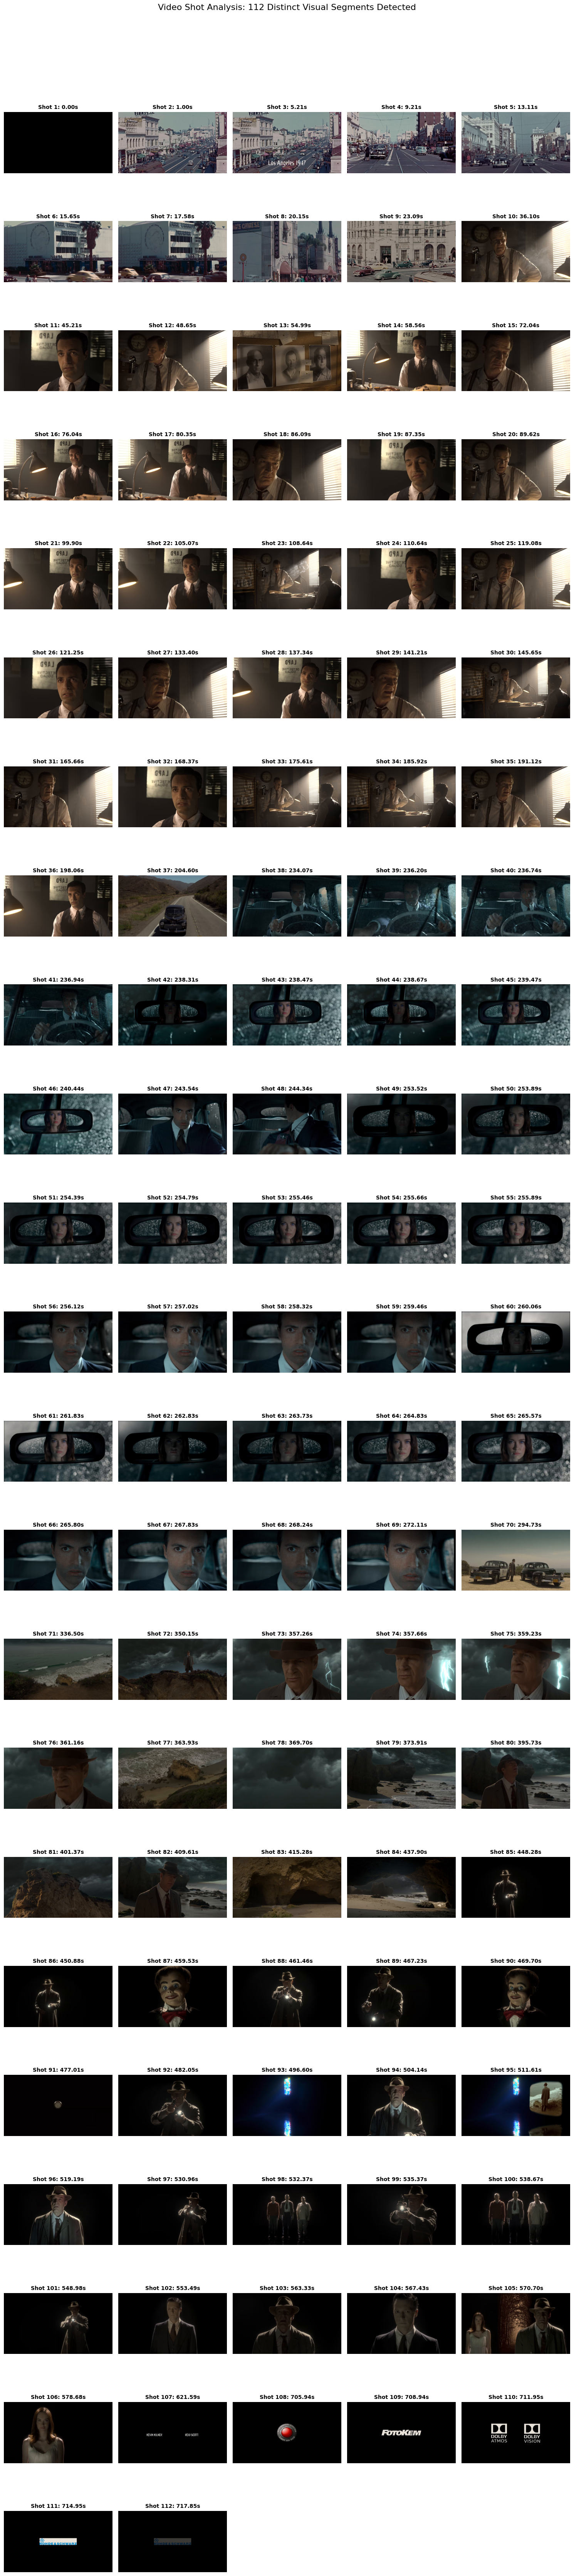

In [8]:
# Display information about scene detection
show_business_context("scene_detection")

# Display video shots with enhanced visualization
print("=== Video Shot Analysis ===\n")
print("Generating images for each shot in the video...")
shot_images = bda_utils.generate_shot_images(sample_video, result_data)
bda_utils.plot_shots(shot_images)

### Content Moderation Analysis

BDA can detect potentially sensitive or inappropriate content in videos. Let's examine the content moderation results for our video.


Content moderation for video is essential for organizations that process user-generated or 
public video content. BDA provides sophisticated detection of potentially sensitive or inappropriate 
content across both visual and audio components.

### Business Applications

- **Platform Safety**: Ensure video platforms provide safe experiences for all users
- **Brand Protection**: Prevent association with inappropriate or harmful content
- **Legal Compliance**: Meet regulatory requirements for content moderation
- **User Trust**: Build confidence through consistent content standards
- **Advertiser Protection**: Ensure ad placement only on appropriate content

### Moderation Categories

BDA supports 7 official moderation categories for video content:

- **Explicit**: Content of a sexual nature
- **Non-Explicit Nudity of Intimate parts and Kissing**: Non-sexual nudity and intimate physical contact
- **Swimwear or Underwear**: People in minimal clothing
- **Violence**: Violent acts, weapons, blood, and physical harm
- **Drugs & Tobacco**: Drug paraphernalia and tobacco products
- **Alcohol**: Alcoholic beverages and drinking
- **Hate symbols**: Symbols associated with hate groups

### Moderation Dimensions

BDA can detect potentially inappropriate content across multiple dimensions:

- **Visual Moderation**: Detection of sensitive images, gestures, objects
- **Audio Moderation**: Detection of inappropriate speech, sounds, music
- **Text Moderation**: Detection of on-screen text containing sensitive content
- **Contextual Moderation**: Understanding content in context rather than isolation

### Implementation Approaches

Organizations typically implement video moderation using one of these patterns:

1. **Pre-publication Review**: Screen content before making it publicly available
2. **Post-publication Monitoring**: Continuously analyze published content
3. **Hybrid Approach**: Automated moderation with human review for edge cases
4. **Progressive Moderation**: Start with strict automated rules and adjust based on performance


=== Content Moderation Analysis ===

Displaying visual content moderation results for the first chapter:


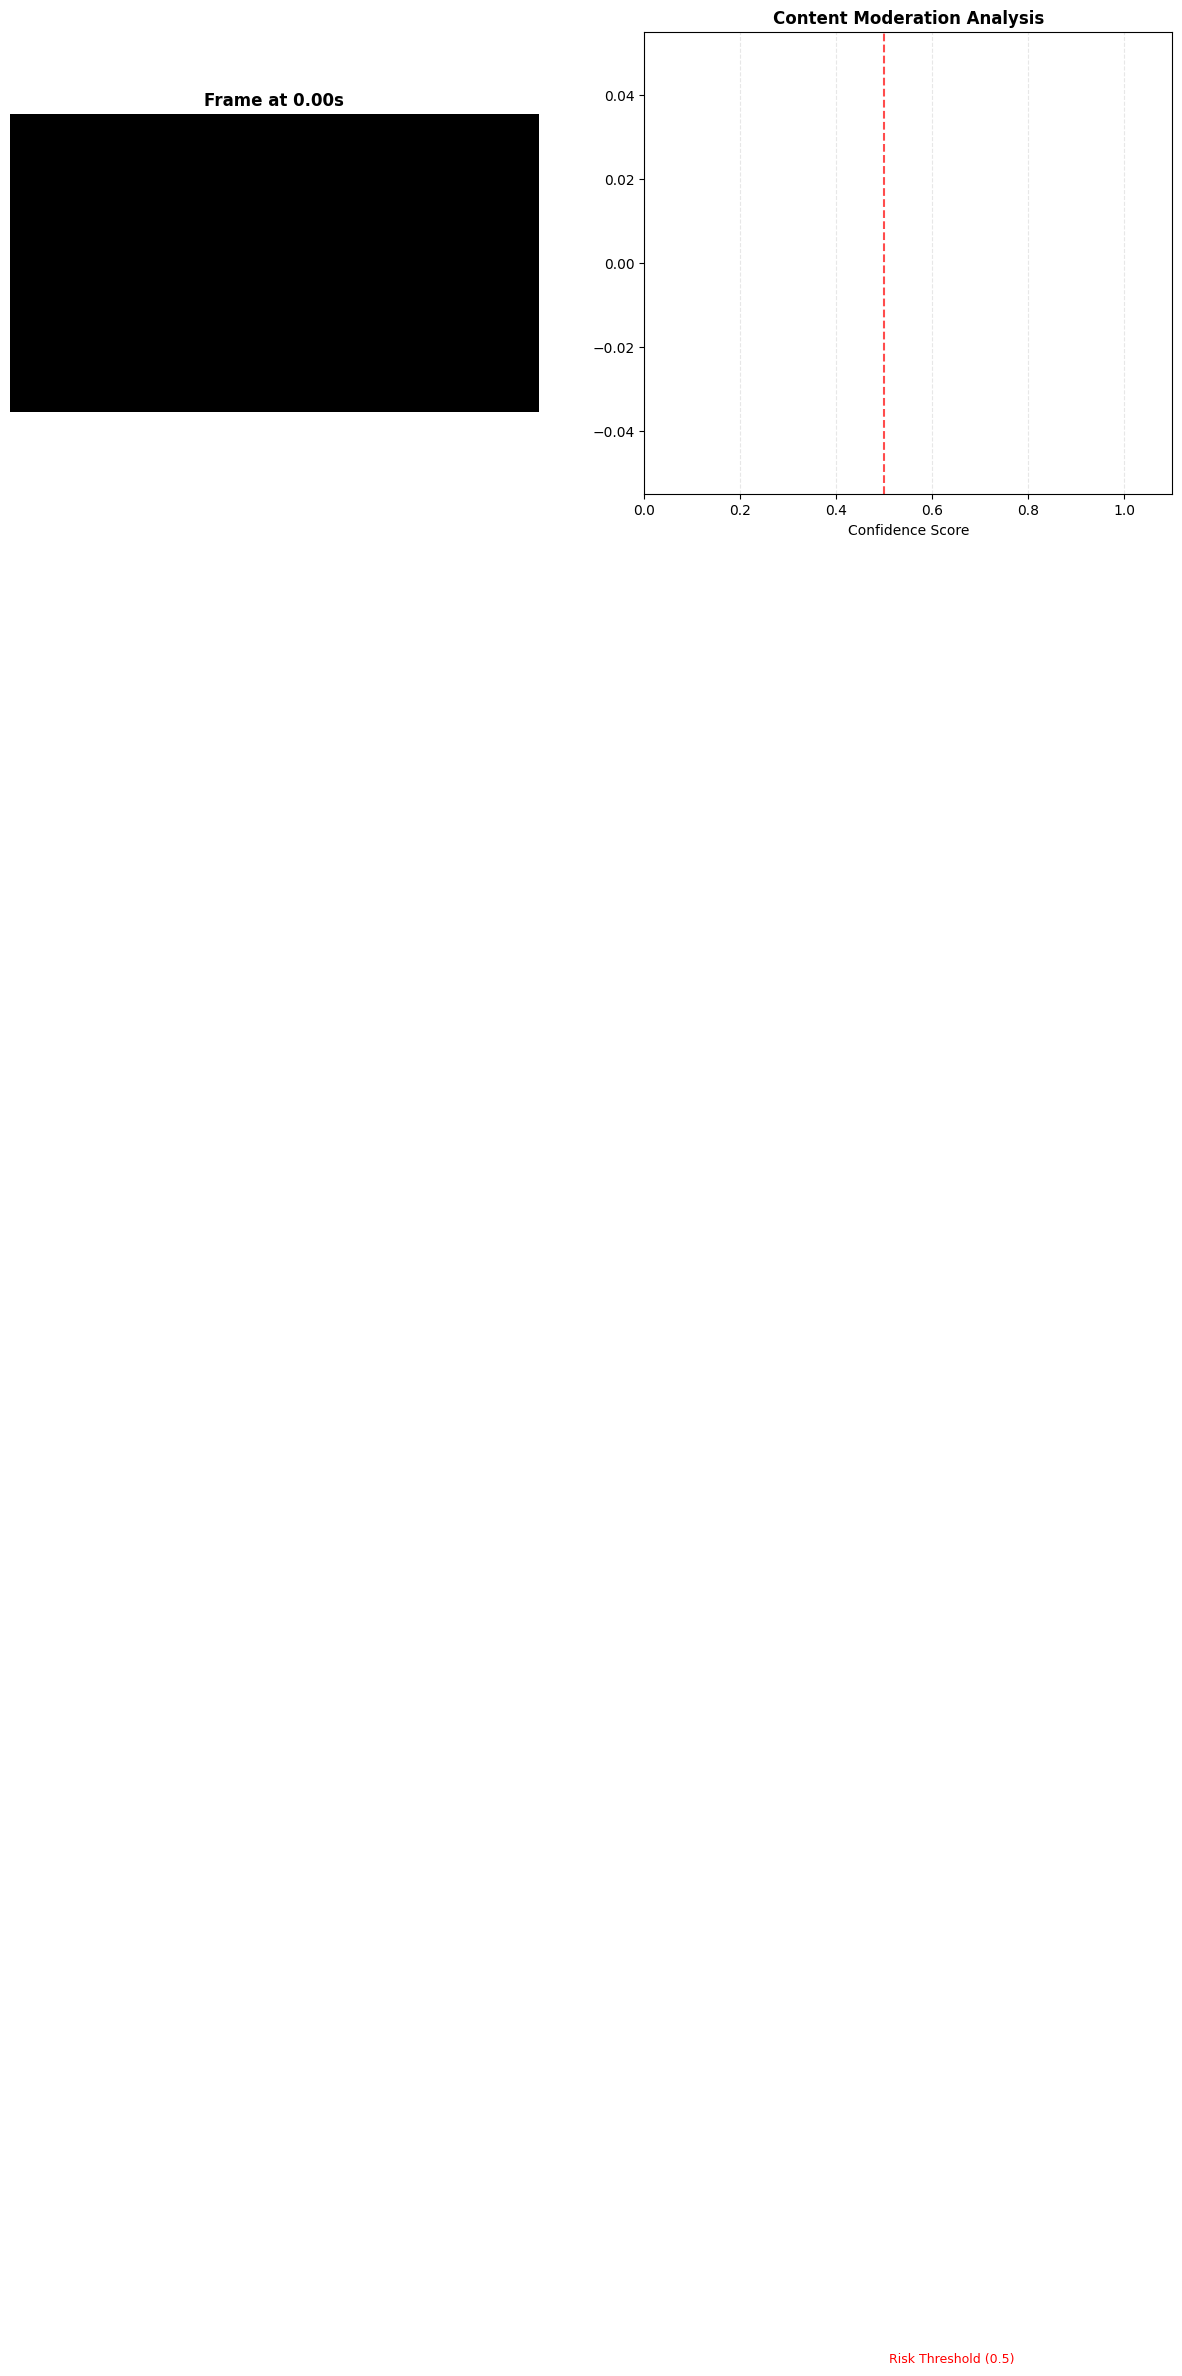

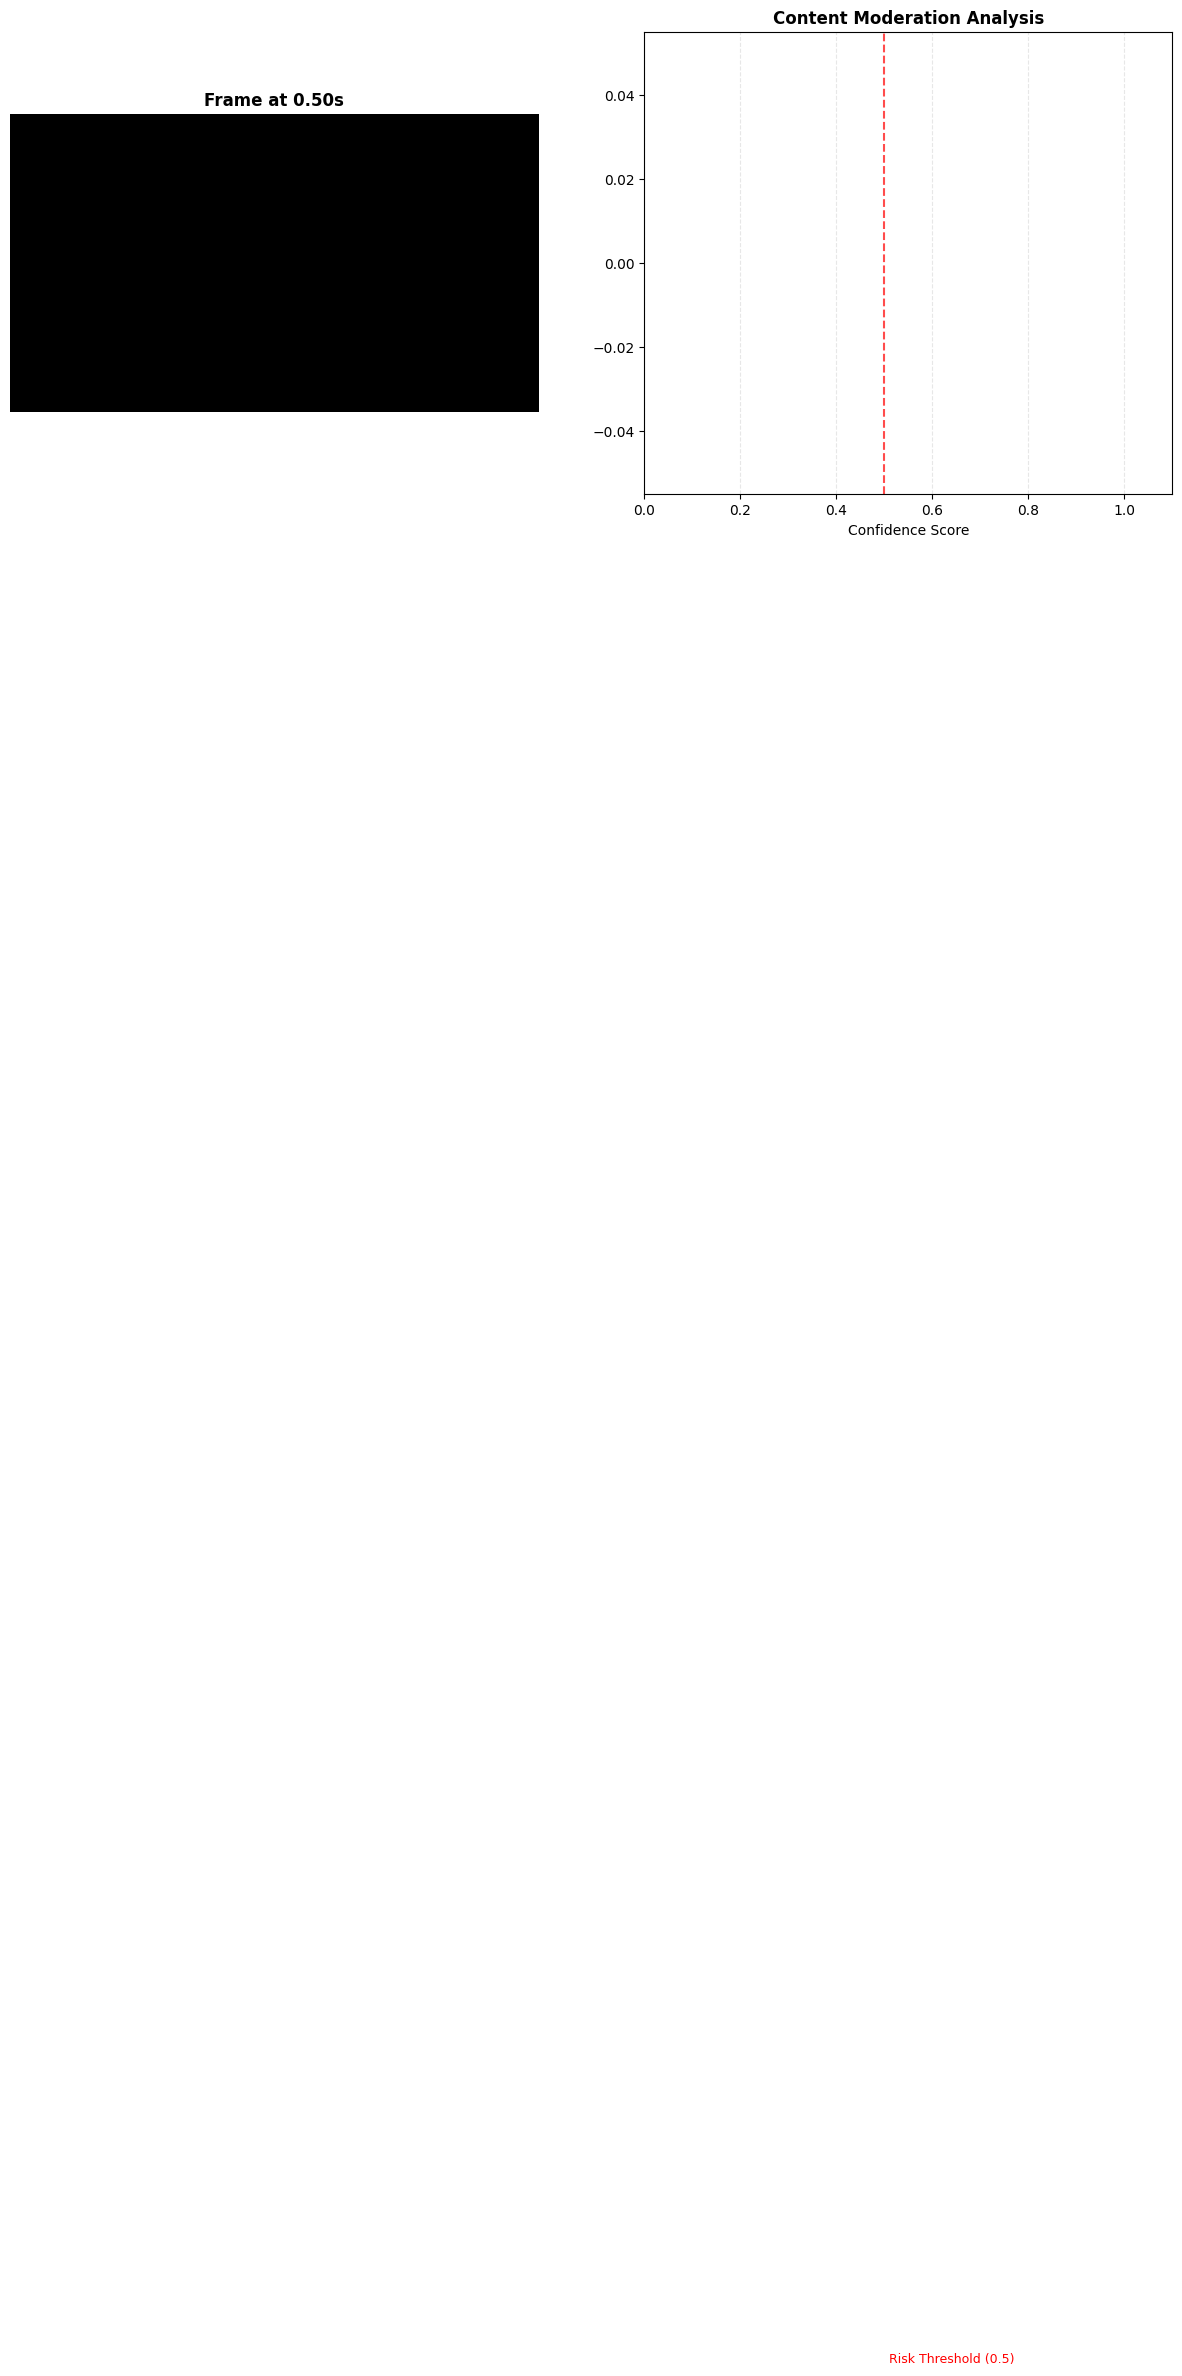

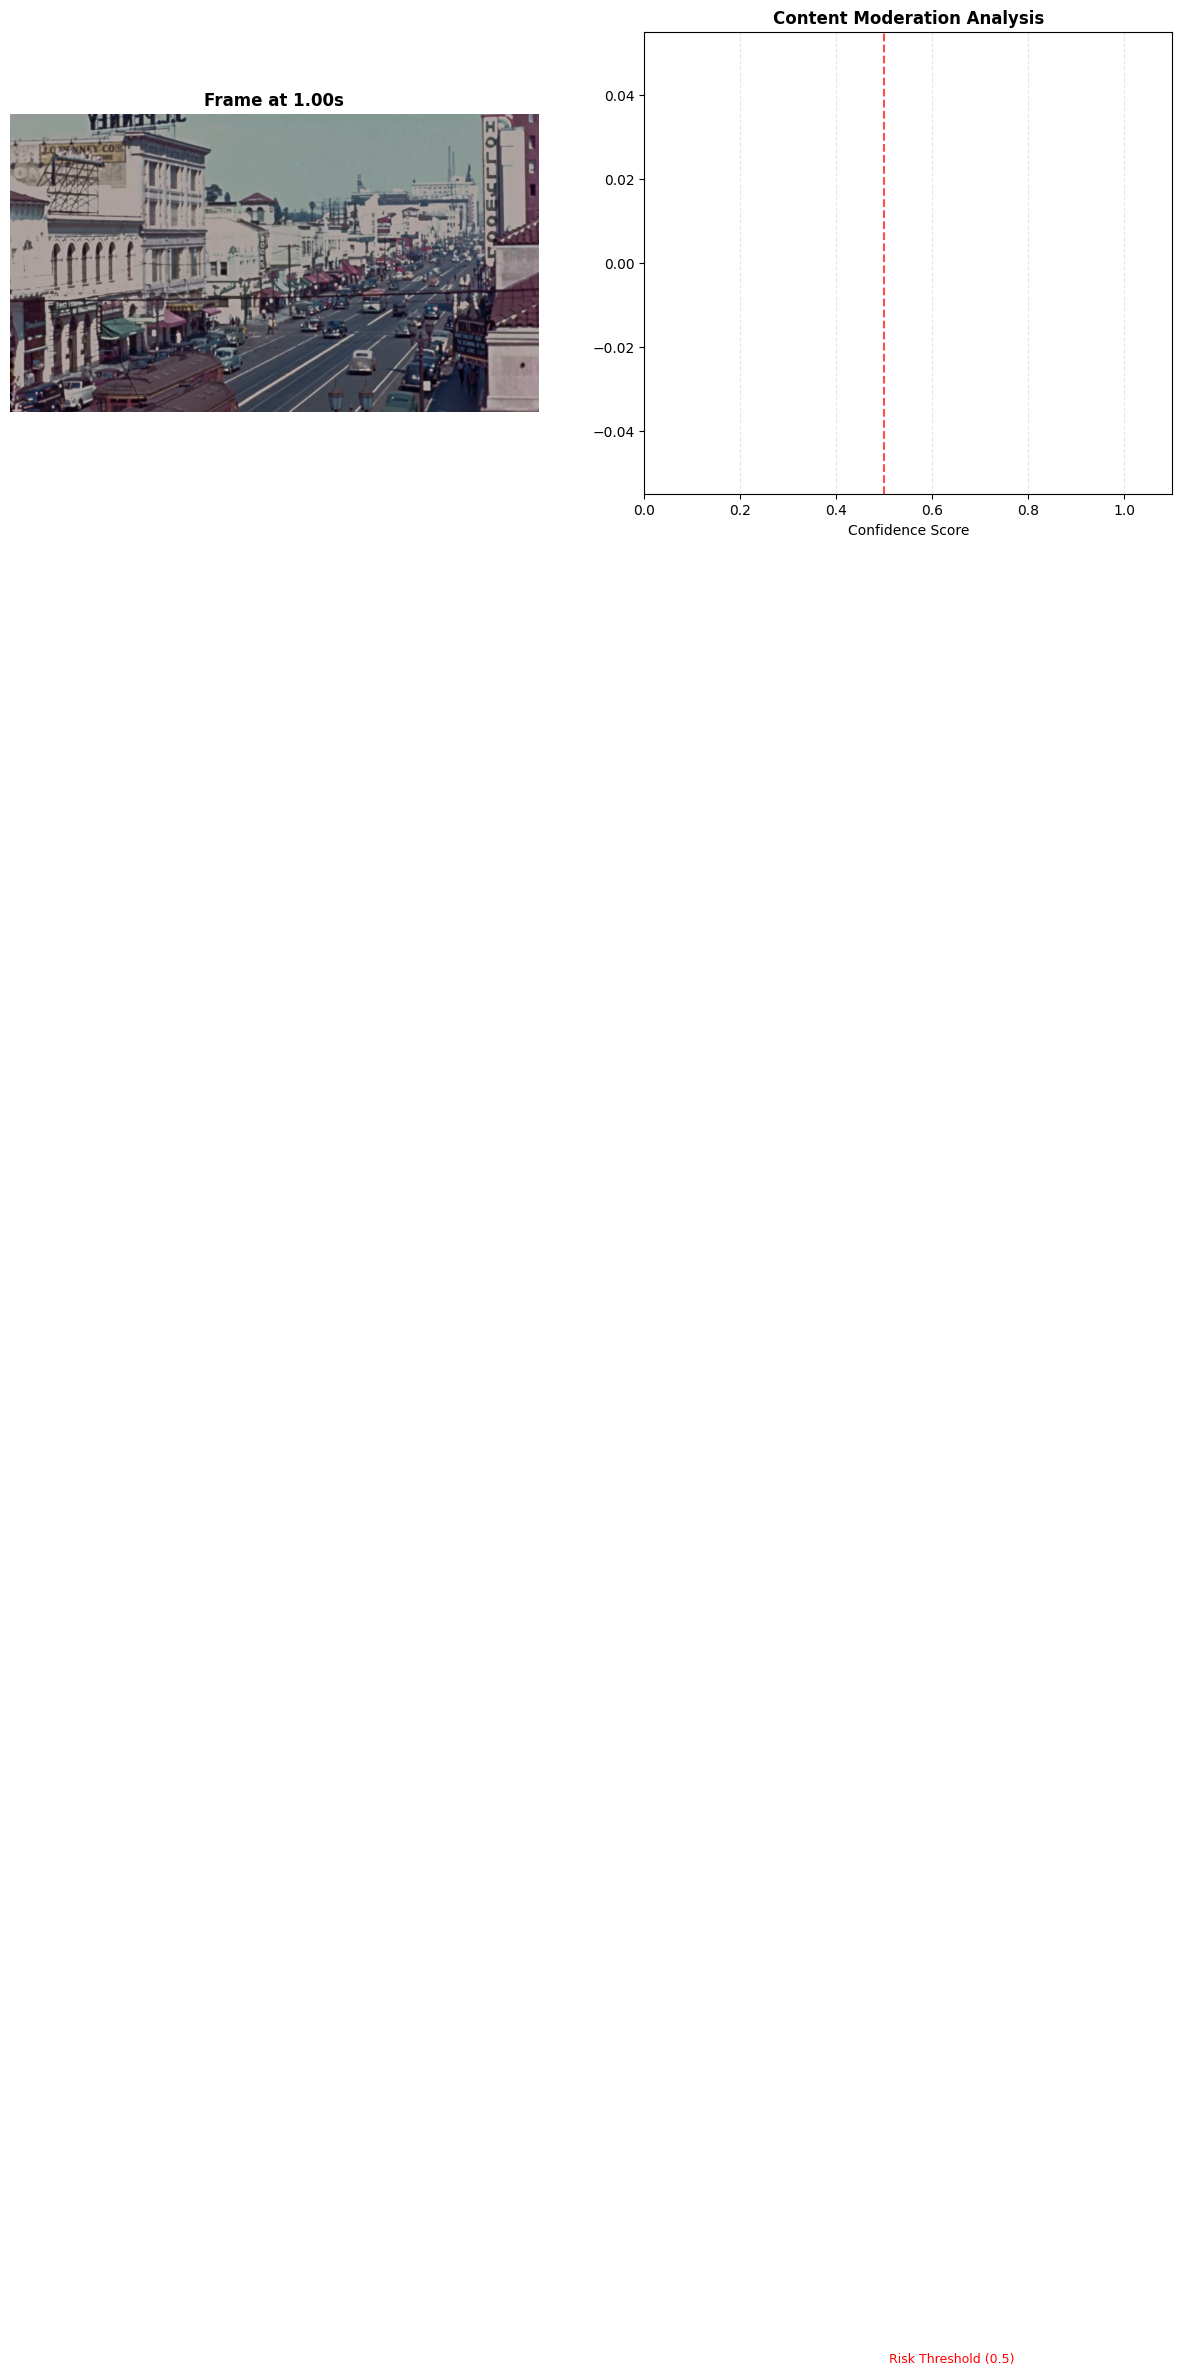


🛡️ Technical Win: BDA automatically detected potentially sensitive content!
This powerful moderation capability helps ensure content safety and compliance.


In [9]:
# Show business context for content moderation
show_business_context("content_moderation")

# Display content moderation results with enhanced visualization
print("=== Content Moderation Analysis ===\n")
print("Displaying visual content moderation results for the first chapter:")
bda_utils.plot_content_moderation(sample_video, result_data, 0)

### Text Detection in Video

BDA can detect and extract text that appears in video frames. This is useful for capturing information displayed on screen, such as titles, captions, or other textual content.

In [10]:
# Show business context for text detection
show_business_context("video_text_detection")

# Function to extract text lines from a frame
def extract_text_lines(frame):
    text_lines = []
    
    # Check all possible locations where text might be stored
    if "features" in frame and "text_lines" in frame["features"]:
        text_lines = frame["features"]["text_lines"]
    elif "text_detection" in frame:
        text_lines = frame["text_detection"]
    elif "text_lines" in frame:
        text_lines = frame["text_lines"]
    
    return text_lines

# Display detected text lines
print("=== Detected Text in Video Frames ===\n")
text_lines_found = False

# Check for text in the frames
for i, chapter in enumerate(result_data["chapters"]):
    for frame in chapter.get("frames", []):
        text_lines = extract_text_lines(frame)
        
        if text_lines:
            text_lines_found = True
            frame_time = frame["timestamp_millis"] / 1000
            print(f"\nText detected at {frame_time:.2f}s:")
            
            for text_line in text_lines:
                confidence = text_line.get("confidence", "N/A")
                detected_text = text_line.get("text", "")
                print(f"- \"{detected_text}\" (Confidence: {confidence})")

if not text_lines_found:
    print("No text detected in the video frames.")
else:
    print("\n🔤 Technical Win: BDA automatically extracted text from video frames!")
    print("This makes previously unsearchable text content in videos discoverable and analyzable.")


Text detection in videos unlocks valuable information that would otherwise remain inaccessible in the visual stream.
BDA can identify, extract, and make searchable text that appears in frames throughout a video.

### Business Applications

- **Subtitle Verification**: Ensure on-screen text matches spoken content
- **Brand Compliance**: Detect unauthorized text or disclaimers
- **Information Extraction**: Capture statistics, names, dates displayed on screen
- **Document Digitization**: Extract text from documents shown in videos
- **UI/UX Analysis**: Analyze text elements in screen recordings or demos

### Types of Video Text

BDA can detect various types of text in videos:

- **Overlay Text**: Captions, titles, and graphics added in post-production
- **Scene Text**: Text naturally appearing within the filmed environment
- **Document Text**: Text appearing in documents shown in videos
- **Interface Text**: Text in UI elements in screen recordings

### Technical Considerations

- Text detection works across multiple languages
- Motion and partial occlusion handling improves detection in dynamic scenes
- Text tracking across frames ensures consistent extraction
- Confidence scores help prioritize high-quality text extractions


=== Detected Text in Video Frames ===


Text detected at 1.00s:
- "J.GOPENNEY CO" (Confidence: 0.4452487)
- "ORE" (Confidence: 0.9813649)
- "BOOKS" (Confidence: 0.9509808)
- "COOESTROI" (Confidence: 0.18915306)
- "Fress PER" (Confidence: 0.24802203)
- "POSE" (Confidence: 0.10564156)
- "HOT" (Confidence: 0.08972794)
- "THE - a TM" (Confidence: 0.65571207)
- "EASY CONE EASY" (Confidence: 0.4906208)

Text detected at 2.00s:
- "J.G.BENNEY.COM" (Confidence: 0.20347925)
- "ORE" (Confidence: 0.981741)
- "COOESTROI" (Confidence: 0.16007377)
- "Past" (Confidence: 0.37547538)
- "RUGS" (Confidence: 0.92247415)
- "- -" (Confidence: 0.46699584)
- "THE II DE" (Confidence: 0.4108754)
- "Los Angeles 1947" (Confidence: 0.8988399)
- "COME East" (Confidence: 0.67032915)
- "a" (Confidence: 0.48545682)

Text detected at 3.00s:
- "J.COPENNEY CO" (Confidence: 0.5146048)
- "ORE" (Confidence: 0.9774664)
- "O" (Confidence: 0.4497801)
- "OOKS" (Confidence: 0.8607891)
- "COOESTROI" (Confidence: 0.19082104)
- "FRE

### Logo Detection

BDA can identify logos and brand marks that appear in videos. This is valuable for brand monitoring, competitive analysis, and content monetization.

In [11]:
# Show business context for logo detection
show_business_context("logo_detection")

# Function to extract logos from a frame
def extract_logos(frame):
    logos = []
    
    # Check all possible locations where logos might be stored
    if "features" in frame and "logos" in frame["features"]:
        logos = frame["features"]["logos"]
    elif "logos" in frame:
        if isinstance(frame["logos"], list):
            logos = frame["logos"]
    
    return logos

# Display detected logos
print("=== Detected Logos ===\n")
logos_found = False

# Check for logos in the frames
for i, chapter in enumerate(result_data["chapters"]):
    for frame in chapter.get("frames", []):
        logos = extract_logos(frame)
        
        if logos:
            logos_found = True
            frame_time = frame["timestamp_millis"] / 1000
            print(f"\nLogos detected at {frame_time:.2f}s:")
            
            for logo in logos:
                confidence = logo.get("confidence", "N/A")
                logo_name = logo.get("name", "Unknown logo")
                print(f"- \"{logo_name}\" (Confidence: {confidence})")

if not logos_found:
    print("No logos detected in the video.")
else:
    print("\n🏢 Technical Win: BDA automatically identified brand logos in the video!")
    print("This enables brand monitoring, competitive analysis, and content monetization opportunities.")


Logo detection provides powerful brand intelligence by identifying commercial marks and symbols
throughout video content. This capability enables brand monitoring, competitor analysis, and
sponsorship valuation.

### Business Applications

- **Brand Exposure Measurement**: Quantify logo appearances in broadcasts
- **Sponsorship Valuation**: Measure actual airtime of sponsored logos
- **Competitive Intelligence**: Track competitor brand appearances
- **Brand Safety**: Ensure brands aren't associated with inappropriate content
- **Content Monetization**: Identify opportunities for brand placement

### Logo Detection Metrics

BDA provides rich logo detection data:

- **Logo Identification**: Which logos appear in the video
- **Temporal Analysis**: When and for how long logos appear
- **Spatial Analysis**: Where on screen the logos appear
- **Prominence Analysis**: How prominent or visible the logos are
- **Context Analysis**: The surrounding content where logos appear

### Implementation Approaches

Organizations leverage logo detection through:

1. **Brand Monitoring**: Track your brand's presence across media
2. **Competitive Analysis**: Compare your brand exposure to competitors
3. **Content Valuation**: Determine value of media based on brand exposure
4. **Media Planning**: Measure ROI of sponsorship and placement investments


=== Detected Logos ===


Logos detected at 14.01s:
- "hollywood" (Confidence: 0.804969)

Logos detected at 15.02s:
- "hollywood" (Confidence: 0.786683)

Logos detected at 288.42s:
- "police" (Confidence: 0.9145003)

Logos detected at 290.42s:
- "police" (Confidence: 0.7570958)
- "police" (Confidence: 0.90601045)

Logos detected at 610.64s:
- "alex and ani" (Confidence: 0.7633443)

Logos detected at 712.68s:
- "dolby" (Confidence: 0.9300902)
- "dolby" (Confidence: 0.8831293)

Logos detected at 713.15s:
- "dolby" (Confidence: 0.9300902)
- "dolby" (Confidence: 0.88312936)

Logos detected at 713.65s:
- "dolby" (Confidence: 0.9300902)
- "dolby" (Confidence: 0.8831293)

Logos detected at 714.15s:
- "dolby" (Confidence: 0.9300902)
- "dolby" (Confidence: 0.88312936)

🏢 Technical Win: BDA automatically identified brand logos in the video!
This enables brand monitoring, competitive analysis, and content monetization opportunities.


### IAB Category Analysis

BDA can classify video content according to the Internet Advertising Bureau (IAB) content taxonomy. This provides standardized categorization for content discovery, ad targeting, and organization.


IAB categorization provides standardized content classification following the Internet Advertising Bureau (IAB)
taxonomy. This allows organizations to consistently categorize content for advertising, recommendation, 
and discovery purposes.

### Business Applications

- **Ad Targeting**: Align advertisements with relevant content categories
- **Content Discovery**: Improve recommendation systems with standardized categories
- **Content Organization**: Create consistent taxonomies across video libraries
- **Audience Analysis**: Understand viewer interests through content preferences
- **Brand Safety**: Identify content categories to include or exclude for ad placement

### IAB Taxonomy Support

Amazon Bedrock Data Automation supports comprehensive IAB taxonomy classification:

- **Coverage**: 24 top-level (L1) categories and 85 second-level (L2) categories
- **Scene-Level Analysis**: Categories assigned to individual chapters for precise targeting
- **Confidence Scores**: Each category assignment includes confidence metrics
- **Multi-Category Classification**: Content can be assigned multiple relevant categories simultaneously

### IAB Taxonomy Examples

The IAB Content Taxonomy includes categories such as:

- **Arts & Entertainment**: Movies, Television, Music, Celebrities
- **Business**: Finance, Marketing, Management, Entrepreneurship
- **Computers & Electronics**: Software, Hardware, Mobile, Gaming
- **Health & Fitness**: Exercise, Nutrition, Medical, Wellness
- **Home & Garden**: Interior Design, DIY, Gardening, Real Estate
- **News & Politics**: Current Events, Government, Economy
- **Sports**: Team Sports, Individual Sports, Outdoor Activities
- **Travel**: Destinations, Hotels, Transportation, Tourism

### Implementation Approaches

Organizations apply IAB categorization through:

1. **Content Tagging**: Automatically tag videos with standardized categories
2. **Ad Inventory**: Create categorized ad inventory for programmatic buying
3. **Content Filtering**: Enable category-based filtering for viewers
4. **Analytics**: Track performance and engagement by content category
5. **Contextual Advertising**: Match advertisements to content based on IAB categories


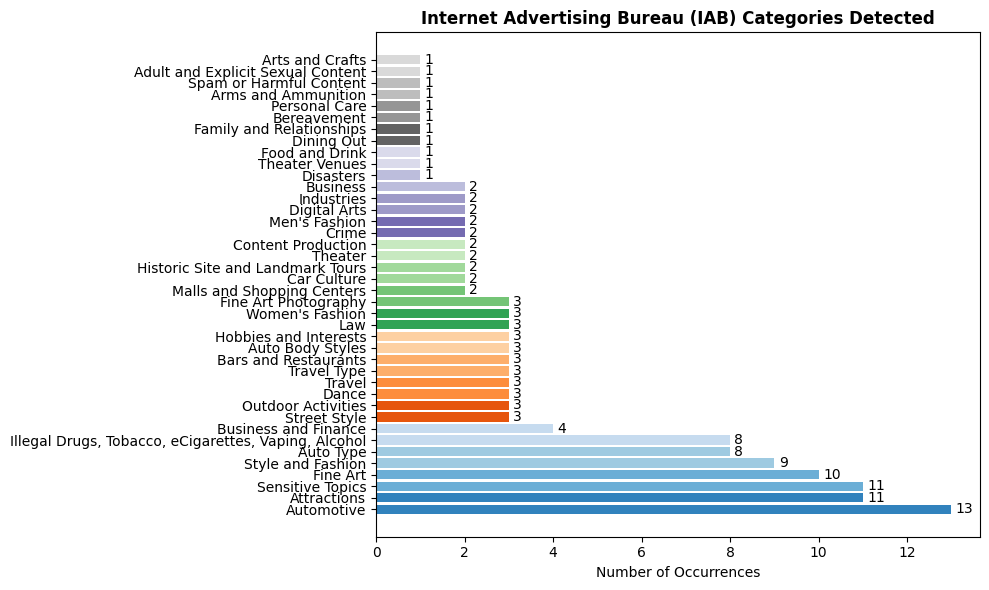


🏷️ Technical Win: BDA automatically classified your video content into IAB categories!
This enables improved content discovery, ad targeting, and content recommendations.


In [12]:
# Show business context for IAB categorization
show_business_context("iab_categorization")

# Visualize IAB categories
bda_utils.visualize_iab_categories(result_data)

## Connecting the Dots: From Images to Audio to Video

Throughout this workshop series, we've explored how Amazon Bedrock Data Automation can extract structured insights from different content modalities:

1. **Document Analysis**: We began with document extraction, learning how to transform static PDFs into structured data.

2. **Image Analysis**: We moved beyond text to extract visual insights from images, detecting objects, text, and concepts.

3. **Audio Analysis**: We unlocked the voice of information by processing spoken content and identifying speakers.

4. **Video Analysis**: Now, we've seen how BDA can process the most complex modality - video - which combines visual, audio, and temporal elements into a rich information stream.

The power of BDA comes from its ability to handle these diverse modalities through a consistent API pattern:

```python
# Create a project with appropriate configuration
project_response = bda_client.create_data_automation_project(...)

# Process content asynchronously
invocation_response = bda_runtime_client.invoke_data_automation_async(...)

# Wait for completion using our flexible pattern
status_response = wait_for_completion(...)

# Analyze results
result_data = read_json_from_s3(output_path)
```

This consistent approach allows you to build applications that can extract insights from any content type, opening up new possibilities for content understanding, search, and analysis.

## Looking Forward: From Understanding to Intelligence

In the next module, we'll take the final step in our journey by combining all these modalities into a unified multimodal RAG (Retrieval-Augmented Generation) system. We'll see how the structured data extracted by BDA from documents, images, audio, and video can be integrated into a knowledge base for intelligent query answering.

You'll learn how to:
- Create a multimodal knowledge base that incorporates insights from all content types
- Build intelligent query capabilities that can reference cross-modal content
- Design applications that deliver comprehensive answers by synthesizing information from various sources
- Create truly intelligent systems that understand not just individual modalities, but their relationships and contexts

This final step will complete our journey from raw, unstructured data to actionable intelligence across the full spectrum of content types.